## `Import Libraries`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
import pandas as pd



In [9]:
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"seaborn=={sns.__version__}")
print(f"joblib=={joblib.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"tensorflow=={tf.__version__}")


pandas==2.1.4
numpy==1.26.4
matplotlib==3.10.8
seaborn==0.13.2
joblib==1.4.2
sklearn==1.6.0
tensorflow==2.18.0


## `Get the Dataset`

In [2]:
# read dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## `EDA`

In [3]:
df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

## `Feature Engineering`

In [4]:
# Add 1 to add the passenger himself
df['family_size'] = df['sibsp'] + df['parch'] + 1

# Make another column if he is alone or not
def is_alone(x):
    if x > 1:
        return 0
    else:
        return 1
# apply
df['is_alone'] = df['family_size'].apply(is_alone)

In [5]:
# Check now
df[['sibsp', 'parch', 'family_size', 'is_alone']].head()

,sibsp,parch,family_size,is_alone
0,1,0,2,0
1,1,0,2,0
2,0,0,1,1
3,1,0,2,0
4,0,0,1,1


## `Split Dataset`

In [6]:
# to X & y
choosen_features = ["pclass", "sex", "age", "sibsp", "parch", "family_size", "is_alone", "fare", "embarked"]
X = df[choosen_features]
y = df['survived']

# to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42, stratify=y)

## `Preporcessing`

In [7]:
# divide into subsets
num_cols = ["age", "fare"]
categ_cols = ["sex", "embarked"]
ready_cols = list(set(X_train.columns) - set(num_cols) - set(categ_cols))

# check
print("Numerical cols: ", num_cols)
print("Categorical cols: ", categ_cols)
print("Ready cols: ", ready_cols)

Numerical cols:  ['age', 'fare']
Categorical cols:  ['sex', 'embarked']
Ready cols:  ['pclass', 'parch', 'sibsp', 'family_size', 'is_alone']


In [8]:
# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"))
])

# Ready pipeline
ready_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine all
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('categ', categ_pipeline, categ_cols),
    ('ready', ready_pipeline, ready_cols)
])

# Apply
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [9]:
# Artifcats folder
ARTIFACTS_FOLDER_PATH = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

In [10]:
# Dump pipeline
joblib.dump(preprocessor, os.path.join(ARTIFACTS_FOLDER_PATH, "preprocessor.joblib"))

['/content/artifacts/preprocessor.joblib']

In [11]:
X_train_final.shape, X_test_final.shape

((712, 10), (179, 10))

In [12]:
X_train_final.shape[1]

10

## `Basic NN Model`

In [13]:
# build a simple NN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=128, activation="relu",input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Fitting
history = model.fit(X_train_final, y_train,
          validation_split=0.2,
          epochs=100,
          batch_size=32)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6340 - loss: 0.6629 - val_accuracy: 0.5944 - val_loss: 0.6306
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6213 - loss: 0.6054 - val_accuracy: 0.6923 - val_loss: 0.5887
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7091 - loss: 0.5800 - val_accuracy: 0.7413 - val_loss: 0.5394
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7658 - loss: 0.5015 - val_accuracy: 0.7832 - val_loss: 0.5012
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7837 - loss: 0.5076 - val_accuracy: 0.7483 - val_loss: 0.5068
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7589 - loss: 0.4990 - val_accuracy: 0.8112 - val_loss: 0.4669
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8359 - loss: 0.4382 - val_accuracy: 0.8112 - val_loss: 0.4560
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4282 - val_accuracy: 0.7972 - 

In [15]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7759 - loss: 0.6530 
Test Loss: 0.6864
Test Accuracy: 0.7542 %


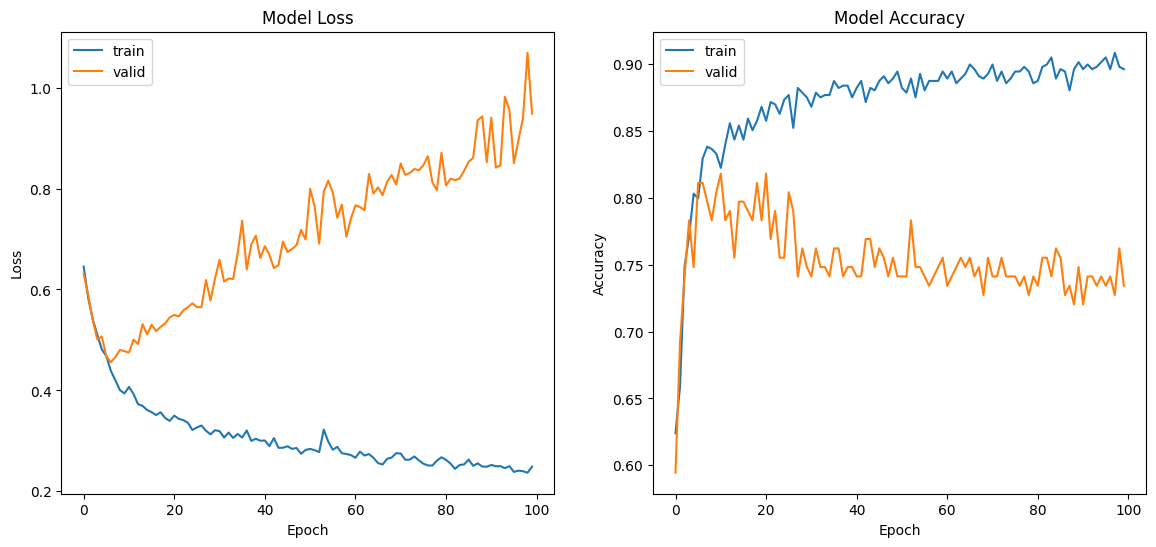

In [16]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Enhancing Model`

In [17]:
# build a simple NN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=128, activation="relu", input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Fitting
history = model.fit(X_train_final, y_train,
          validation_split=0.2,
          epochs=100,
          batch_size=32)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5767 - loss: 0.6946 - val_accuracy: 0.5944 - val_loss: 0.6487
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6303 - loss: 0.6419 - val_accuracy: 0.5944 - val_loss: 0.6246
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6030 - loss: 0.6686 - val_accuracy: 0.6434 - val_loss: 0.6264
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6152 - loss: 0.6344 - val_accuracy: 0.6503 - val_loss: 0.6038
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6360 - loss: 0.6318 - val_accuracy: 0.6993 - val_loss: 0.5934
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6727 - loss: 0.5993 - val_accuracy: 0.6923 - val_loss: 0.5725
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6807 - loss: 0.6076 - val_accuracy: 0.7413 - val_loss: 0.5575
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6917 - loss: 0.5865 - val_accuracy: 0.7483 - 

In [19]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7938 - loss: 0.4705 
Test Loss: 0.4754
Test Accuracy: 0.7877 %


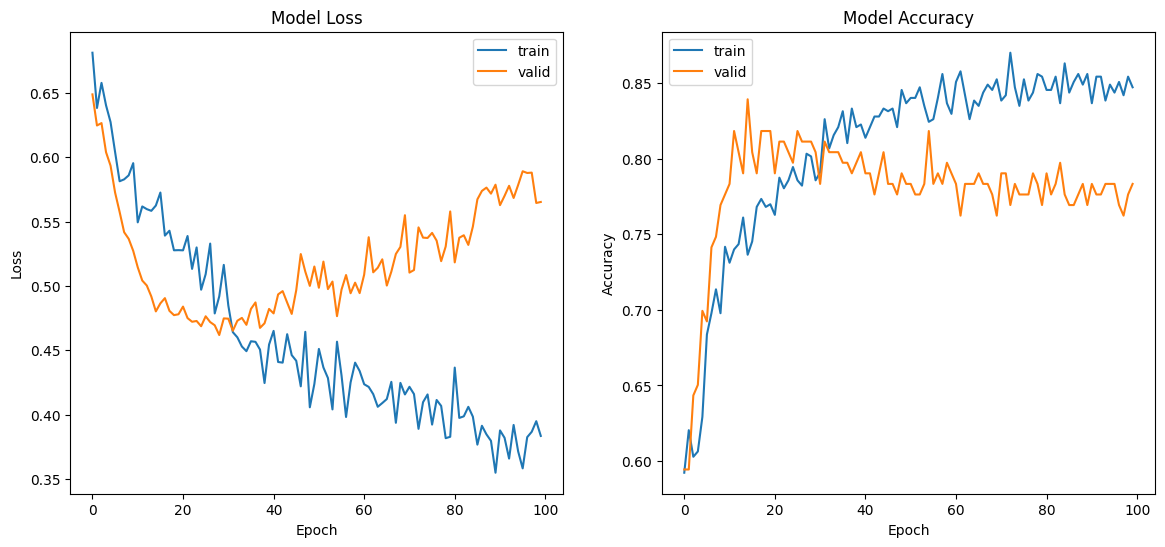

In [20]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
# Try add a reguralizer l2
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Early Stopping
early_stopp = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# Fit
histroy = model.fit(X_train_final, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopp])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6137 - loss: 2.2519 - val_accuracy: 0.6014 - val_loss: 1.9688
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6252 - loss: 1.8794 - val_accuracy: 0.7133 - val_loss: 1.6859
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7077 - loss: 1.6040 - val_accuracy: 0.7413 - val_loss: 1.4529
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7108 - loss: 1.3852 - val_accuracy: 0.7692 - val_loss: 1.2667
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7117 - loss: 1.2425 - val_accuracy: 0.7552 - val_loss: 1.1205
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7910 - loss: 1.0616 - val_accuracy: 0.7762 - val_loss: 1.0035
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7807 - loss: 0.9852 - val_accuracy: 0.8042 - val_loss: 0.9109
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8007 - loss: 0.8847 - val_accuracy: 0.7622 - 

In [23]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7807 - loss: 0.5606 
Test Loss: 0.5451
Test Accuracy: 0.8045 %


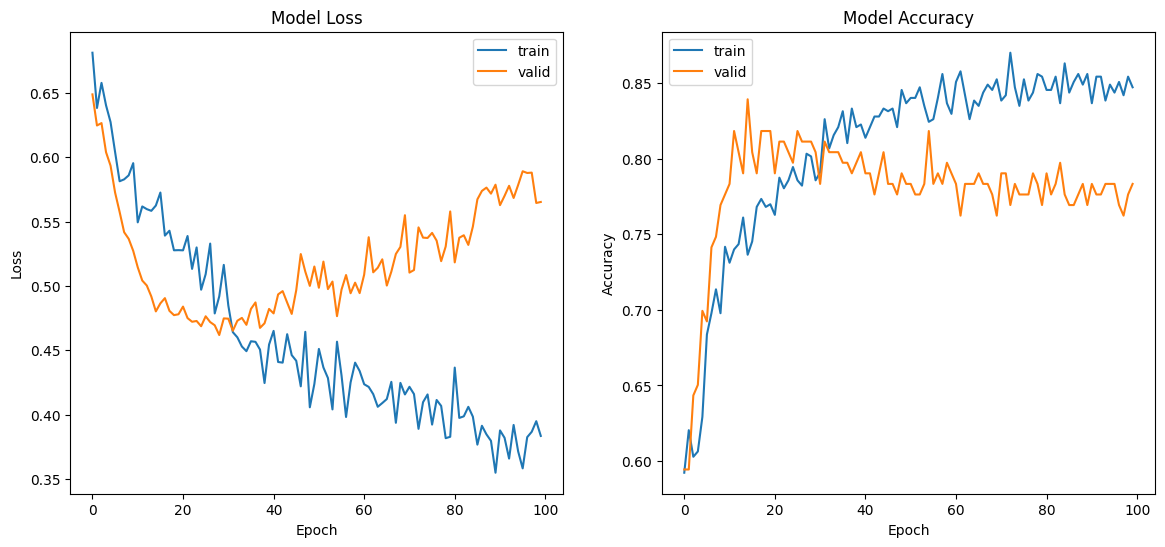

In [24]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Using Keras-Tuner`

In [ ]:
# !pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.1 MB/s eta 0:00:00


In [26]:
from kerastuner import RandomSearch

/tmp/ipython-input-659161079.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [27]:
def build_model(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_final.shape[1],)),

        # First Layer
        tf.keras.layers.Dense(
            units=hp.Int('units_1', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_1', ['relu', 'tanh', 'elu', 'selu']),
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ),

        tf.keras.layers.Dropout(
            hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
        ),

        # Second Layer
        tf.keras.layers.Dense(
            units=hp.Int('units_2', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_2', ['relu', 'tanh', 'elu', 'selu']),
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ),

        tf.keras.layers.Dropout(
            hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
        ),

        # Third Layer
        tf.keras.layers.Dense(
            units=hp.Int('units_3', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_3', ['relu', 'tanh', 'elu', 'selu']),
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ),

        tf.keras.layers.Dropout(
            hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)
        ),

        # Fourth Layer
        tf.keras.layers.Dense(
            units=hp.Int('units_4', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_4', ['relu', 'tanh', 'elu', 'selu']),
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ),

        tf.keras.layers.Dropout(
            hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)
        ),

        # Output Layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [28]:
tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="hyperparameter_tuning_4",
    project_name="titanic_project",
    seed=174
)

In [29]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [30]:
# Running tuner
tuner.search(X_train_final, y_train,
             epochs=50,
             batch_size=32,
             validation_split=0.2,
             callbacks=[early_stopping],
             )

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.8286713063716888

Best val_accuracy So Far: 0.8356643319129944
Total elapsed time: 00h 03m 43s


In [31]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [32]:
# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8051 - loss: 0.5813 
Test Loss: 0.5709
Test Accuracy: 0.8101 %


In [33]:
#import tensorflow as tf
#tf.keras.backend.clear_session()

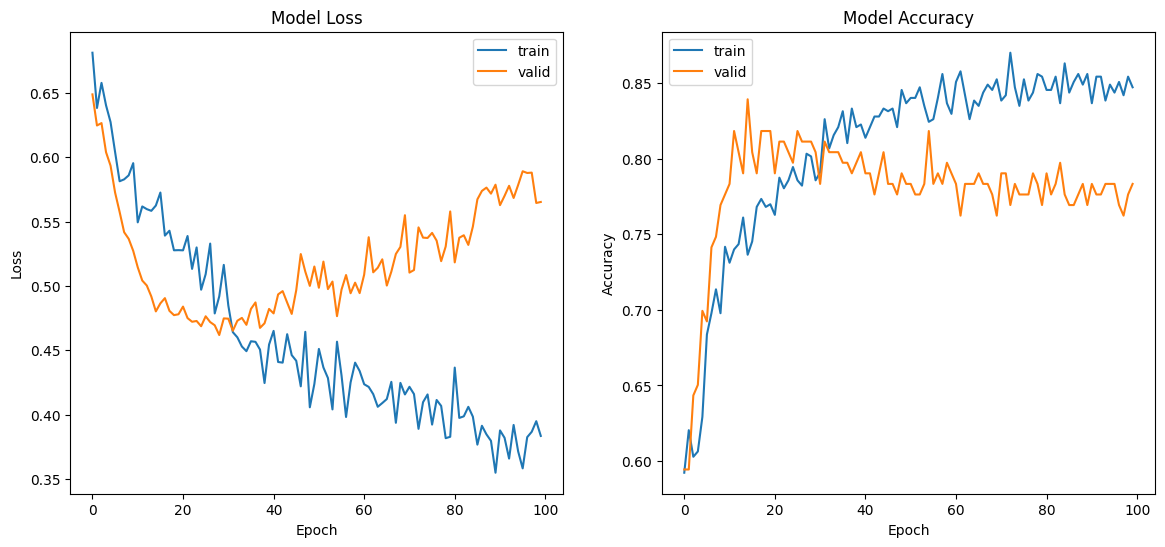

In [34]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
# Save the model locally
best_model.save(os.path.join(ARTIFACTS_FOLDER_PATH, "best_model.keras"))

In [36]:
# Load pretrained model
model = tf.keras.models.load_model(os.path.join(ARTIFACTS_FOLDER_PATH, "best_model.keras"))

# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8051 - loss: 0.5813 
Test Loss: 0.5709
Test Accuracy: 0.8101 %


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### `Inference`

In [37]:
# Imagine that these are some samples
samples = df.sample(10, random_state=14)

# Processing
samples_processed = preprocessor.transform(samples)

# Predict
predictions = (model.predict(samples_processed) > 0.5).astype("int32")

predictions.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

In [38]:
results = pd.DataFrame({
    'Passenger_ID': samples["passengerid"],
    'Predicted': ['Survived' if pred == 1 else 'Not Survived' for pred in predictions.flatten()],
})

results

,Passenger_ID,Predicted
75,76,Not Survived
602,603,Not Survived
119,120,Not Survived
647,648,Not Survived
115,116,Not Survived
472,473,Survived
547,548,Not Survived
735,736,Not Survived
467,468,Not Survived
759,760,Survived
